# Oversampling on class + more Grid search

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

Importing datasets manually

In [4]:
df_red = pd.read_csv('../winequality-red.csv', sep=';')

df_white = pd.read_csv('../winequality-white.csv', sep=';')

I add a color column to the datasets

In [5]:
df_red['color'] = 0    # per red
df_white['color'] = 1  # per white

df_red

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,0
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6,0
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6,0
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5,0


i'm applying oversampling to the red dataset so it does not have a lot less values than white

In [6]:

X_red = df_red.drop(columns='quality')
y_red = df_red['quality']

smote = SMOTE(random_state=42)
X_red_resampled, y_red_resampled = smote.fit_resample(X_red, y_red)

I concatenate the red and white datasets to have a single one

In [7]:
red_wine_resampled = pd.concat([
    pd.DataFrame(X_red_resampled, columns=X_red.columns),
    pd.Series(y_red_resampled, name='quality')
], axis=1)

data = pd.concat([red_wine_resampled, df_white], ignore_index=True)

data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,6
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,5
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,6
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,7


## Regrouping the target classes

3--4 $\rightarrow$ 1;   
5 $\rightarrow$ 2;  
6 $\rightarrow$ 3;  
7--8--9 $\rightarrow$ 4;    



In [8]:
data['quality'] = data['quality'].replace({
    3: 1, 4: 1,
    5: 2,
    6: 3,
    7: 4, 8: 4, 9: 4
})


In [9]:
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,0,2
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,0,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,0,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8979,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,1,3
8980,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,1,2
8981,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,1,3
8982,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,1,4


## Expolaratory Data analysis

We start with a pie chart to look at the proportion of quality levels

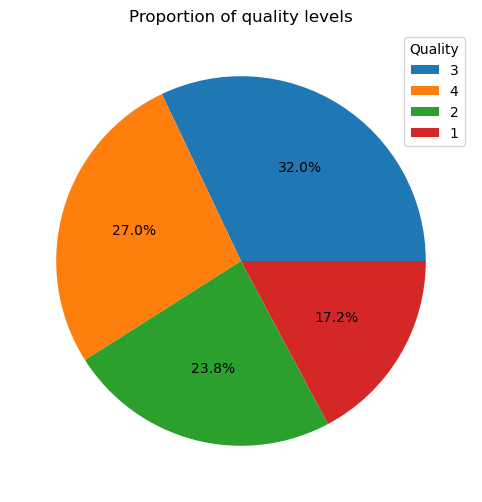

In [10]:
y = data['quality']
count = y.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

The distribution looks acceptable, but I will try applying oversampling to balance the number of occurrences across the different quality categories.

### SMOTE

In [11]:
X = data.drop(columns='quality')
X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color
5526,7.200000,0.260000,0.740000,13.600000,0.050000,56.000000,162.000000,0.998000,3.030000,0.440000,8.800000,1
8499,5.800000,0.300000,0.380000,4.900000,0.039000,22.000000,86.000000,0.989630,3.230000,0.580000,13.100000,1
5489,7.100000,0.260000,0.310000,2.200000,0.044000,29.000000,128.000000,0.993700,3.340000,0.640000,10.900000,1
9500,10.996538,0.609544,0.577024,2.074279,0.098264,10.754328,44.737017,1.000034,3.258800,0.562457,9.100577,0
9405,9.994368,0.687746,0.423747,2.390703,0.186073,5.000000,15.729579,0.999021,3.223549,0.617831,8.710984,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11284,7.757571,0.353091,0.415542,3.101172,0.076613,15.527363,33.451136,0.996441,3.319180,0.816298,12.408158,0
5191,5.500000,0.320000,0.450000,4.900000,0.028000,25.000000,191.000000,0.992200,3.510000,0.490000,11.500000,1
5390,8.000000,0.590000,0.710000,17.350000,0.038000,61.000000,228.000000,1.000000,2.950000,0.750000,9.300000,1
860,7.200000,0.620000,0.060000,2.700000,0.077000,15.000000,85.000000,0.997460,3.510000,0.540000,9.500000,0


We can see that the number of observations is now balanced across all classes, indicating that the data has been successfully rescaled using SMOTE.

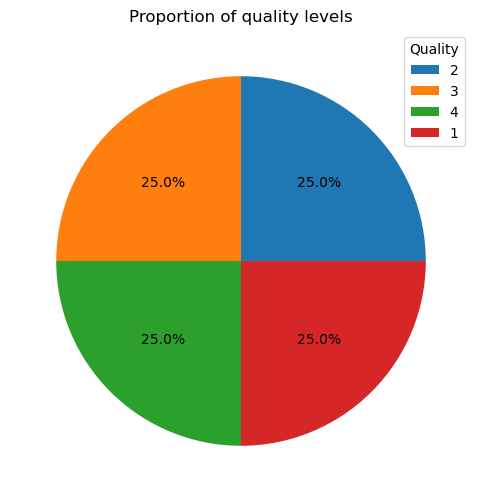

In [12]:
count = y_resampled.value_counts()
plt.figure(figsize=(10, 6))
plt.pie(count, labels=None, autopct='%1.1f%%')
plt.title('Proportion of quality levels')
plt.legend(labels=count.index, title="Quality", loc="best")
plt.show()

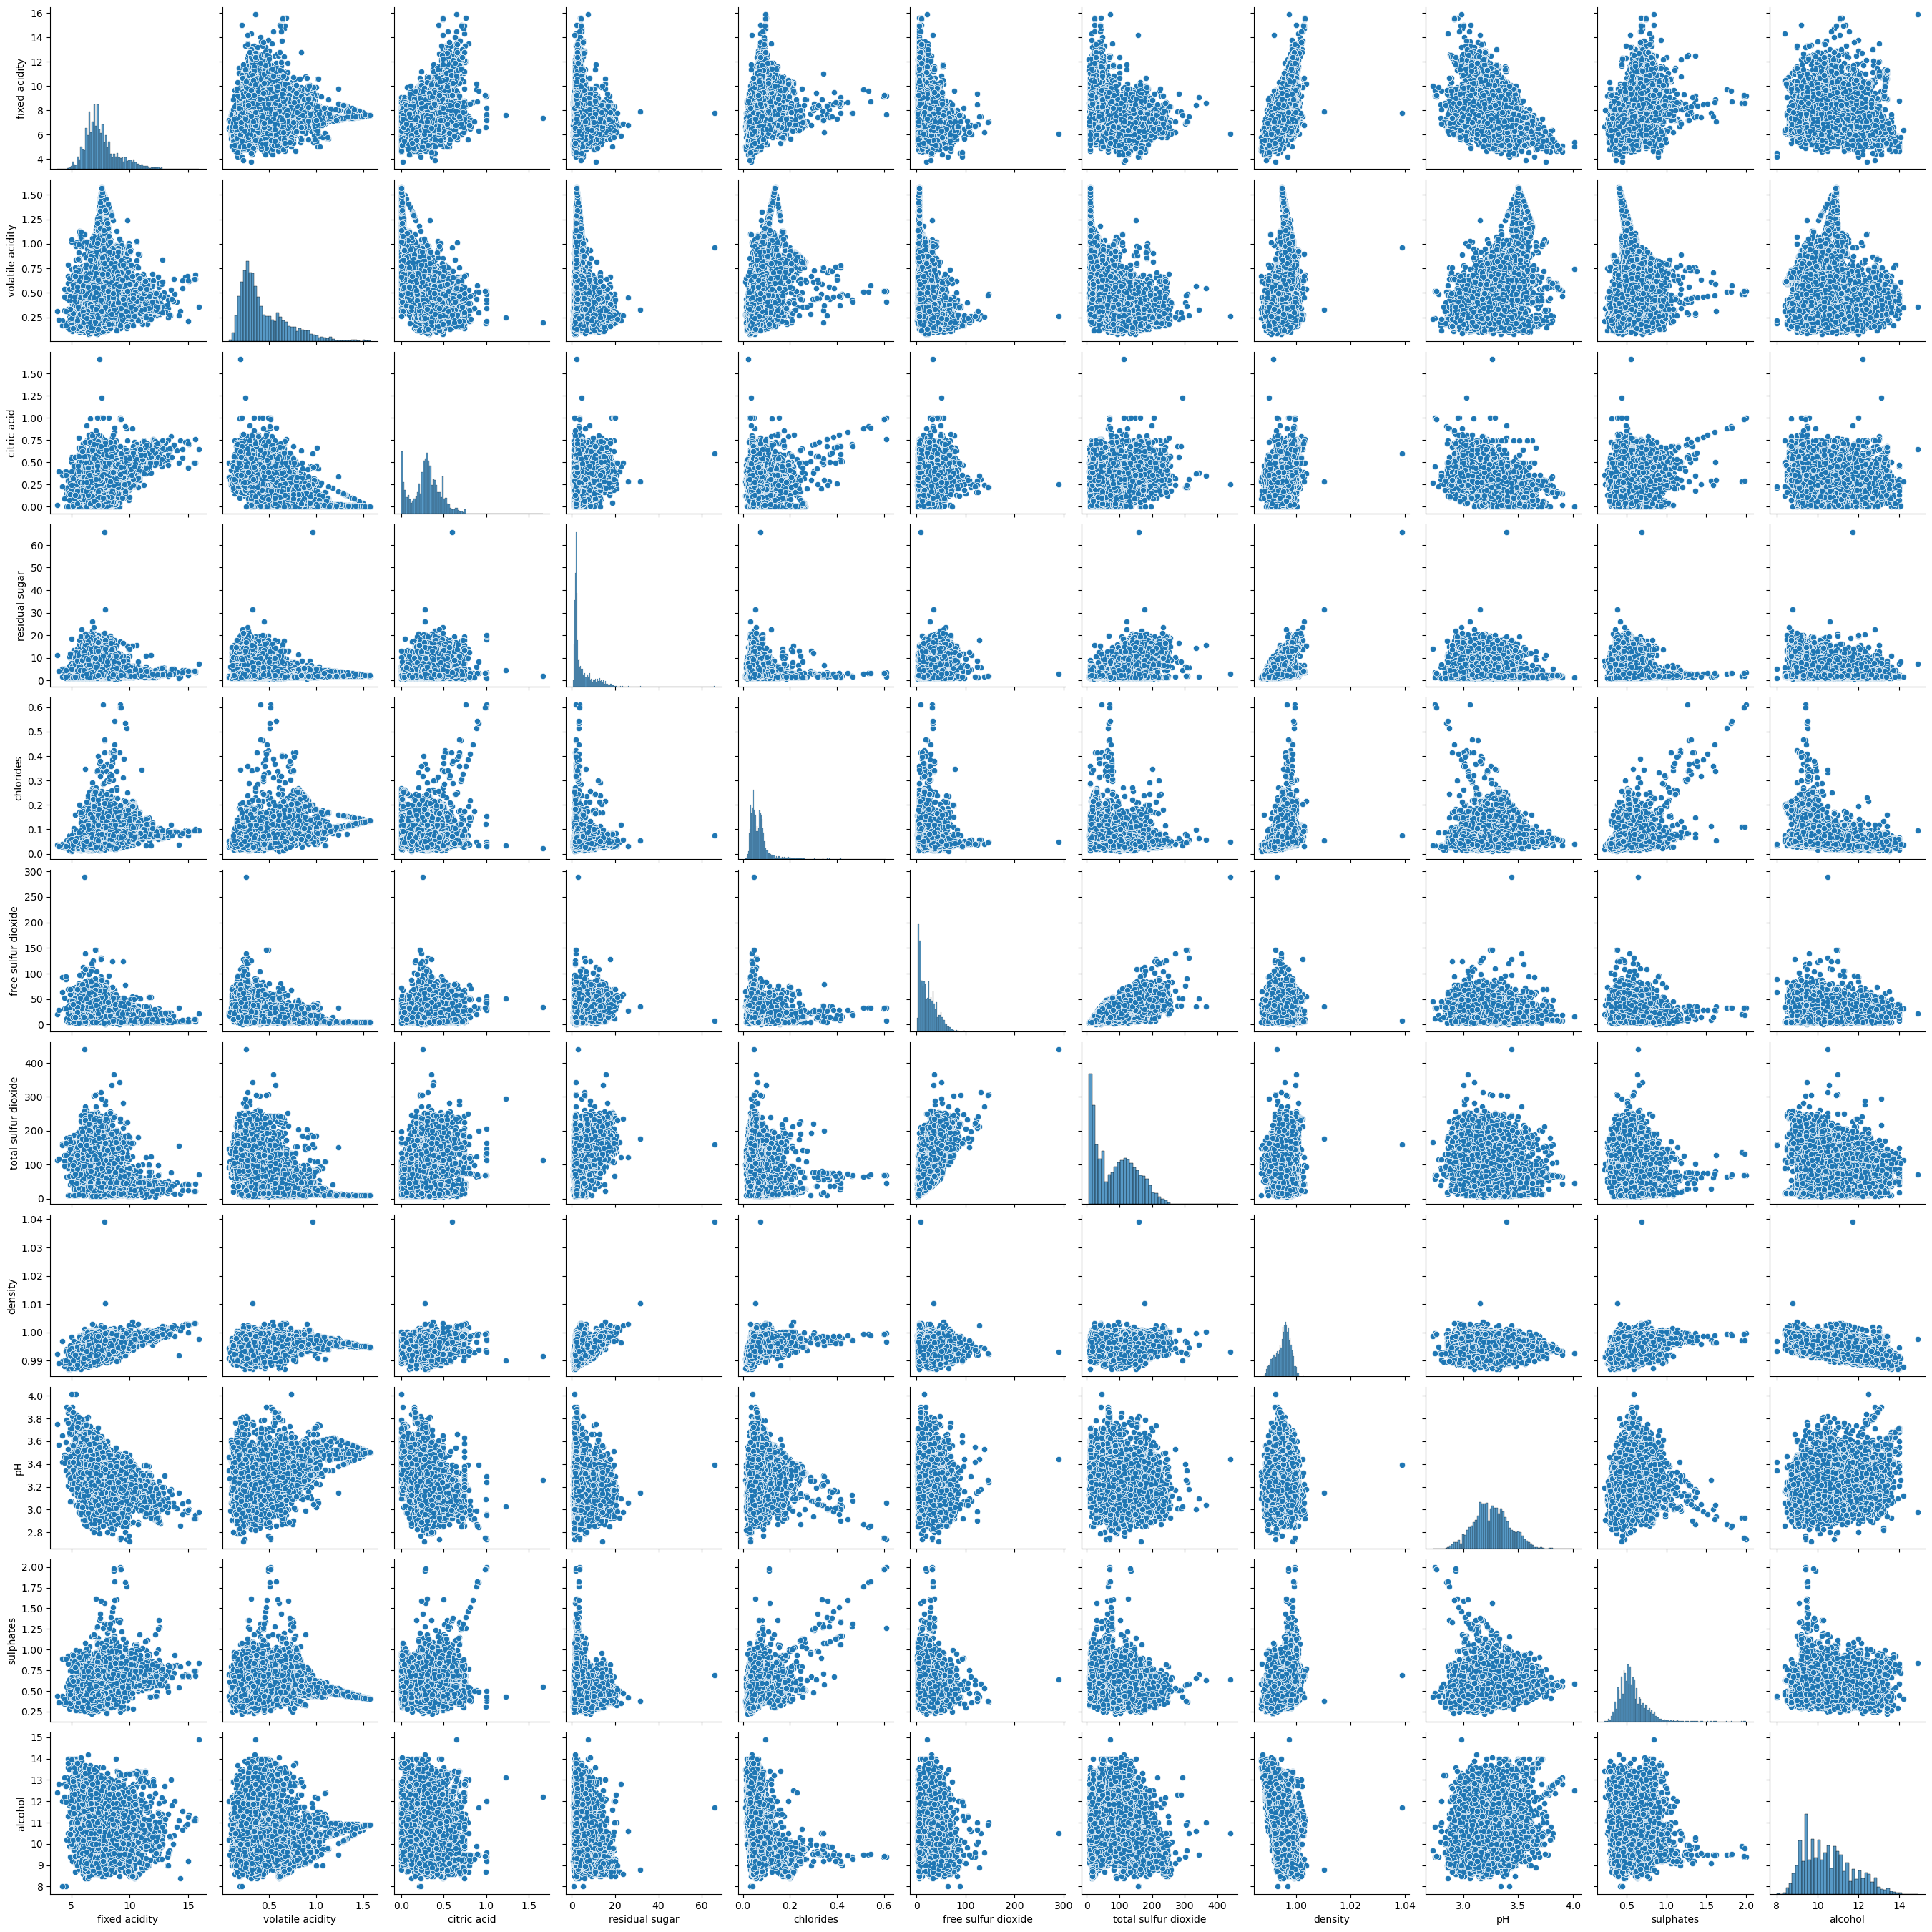

In [13]:
sns.pairplot(X_resampled.drop(columns='color'))

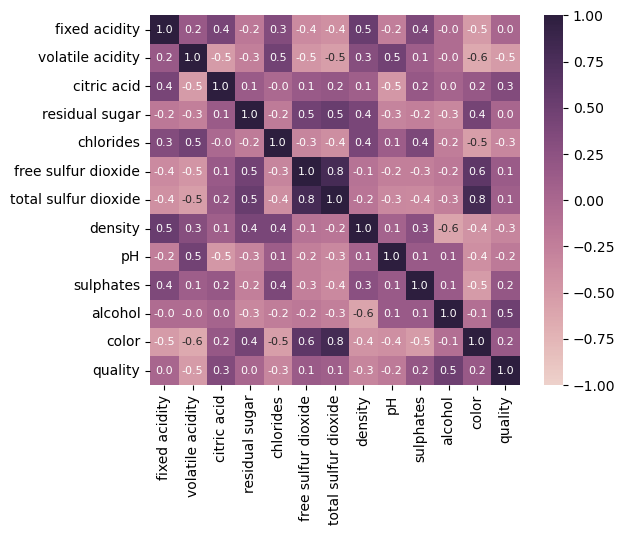

In [14]:
correlation = data.corr()

axis_corr = sns.heatmap(
correlation,
vmin=-1, vmax=1, center=0,
cmap=sns.cubehelix_palette(as_cmap=True),
square=True,
annot=True,
fmt=".1f",
annot_kws={"size": 8}
)

plt.show()

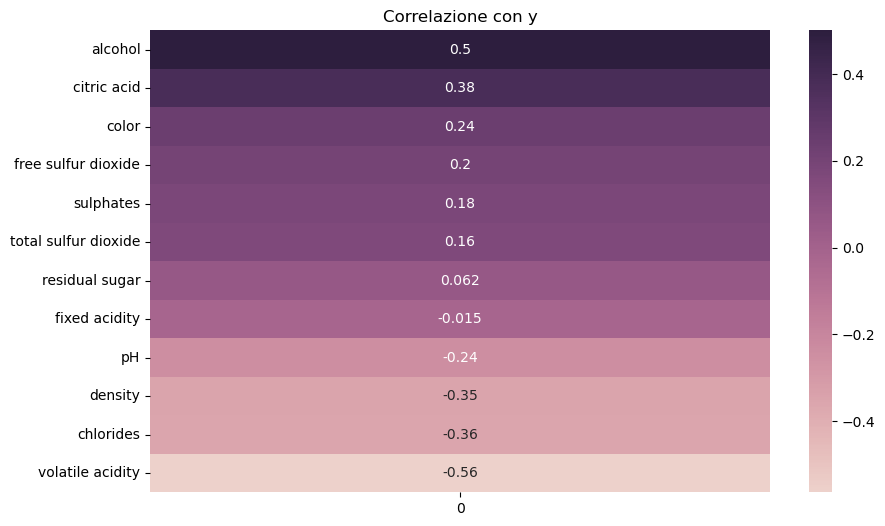

In [15]:
corr = X_resampled.corrwith(y_resampled)

corr_sorted = corr.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_sorted.to_frame(),
    annot=True,
    cmap=sns.cubehelix_palette(as_cmap=True),
)
plt.title('Correlazione con y')
plt.show()

## PCA

In [16]:
X_scaled = X_resampled.copy()

cols_to_scale = X_scaled.columns.difference(['color'])

scaler = StandardScaler()

X_scaled[cols_to_scale] = scaler.fit_transform(X_scaled[cols_to_scale])

In [17]:
pca_full = PCA()
X_pca_full = pca_full.fit_transform(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

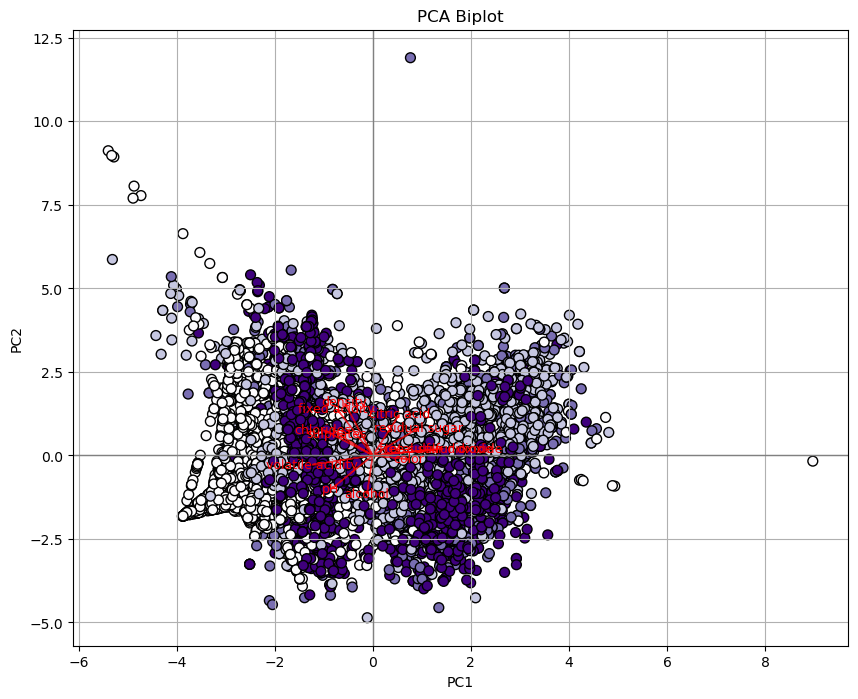

In [18]:
# so che non si vede, ma questa è comunque la cmap con cui si vede di piu
loadings = pca.components_.T 
feature_names = X_scaled.columns

plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='Purples', edgecolor='k', s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot")


for i, feature in enumerate(feature_names):
    plt.arrow(0, 0,
              loadings[i, 0] * 3,
              loadings[i, 1] * 3,
              color='r', alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0] * 3.2, loadings[i, 1] * 3.2,
             feature, color='r', ha='center', va='center', fontsize=9)

plt.grid(True)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.show()


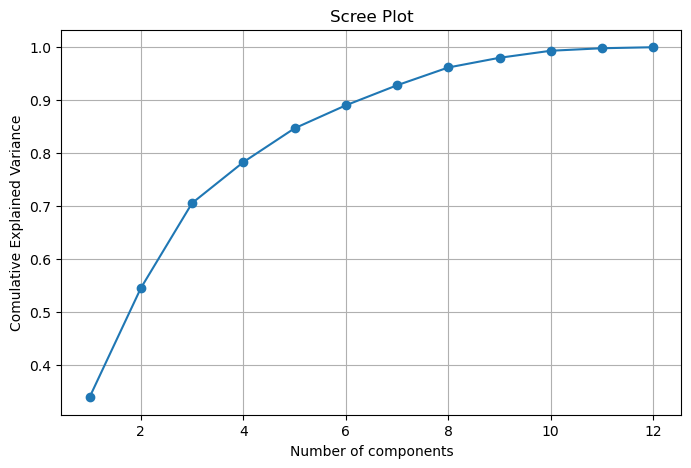

In [19]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_) + 1), np.cumsum(pca_full.explained_variance_ratio_), marker='o')
plt.xlabel('Number of components')
plt.ylabel('Comulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

In [20]:
pve = pca_full.explained_variance_ratio_
for i, v in enumerate(pve):
    print(f"PC{i+1}: {v:.4f}")

PC1: 0.3389
PC2: 0.2060
PC3: 0.1606
PC4: 0.0773
PC5: 0.0640
PC6: 0.0434
PC7: 0.0379
PC8: 0.0336
PC9: 0.0183
PC10: 0.0133
PC11: 0.0047
PC12: 0.0019


# EXPERIMENTS
We start by looking at the best performing models w/o optmization.
First we load the models

In [19]:
models = {
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'MLP': MLPClassifier(max_iter=2000),
    'Decision Tree': DecisionTreeClassifier()
}

We then scale the sets

In [20]:
cols_to_scale = X.columns.difference(['color'])

scaler = StandardScaler()
scaler.fit(X_train[cols_to_scale])

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[cols_to_scale] = scaler.transform(X_train[cols_to_scale])
X_test_scaled[cols_to_scale] = scaler.transform(X_test[cols_to_scale])

And now we train all the models to select the best performing ones.

In [21]:
best_model = None
best_accuracy = 0
results = {}
best_models ={}

for name, model in models.items():
    if name == 'Decision Tree':
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

    if acc >= 0.7:
        best_models[name] = model


    if acc > best_accuracy:
        best_accuracy = acc
        best_model = name

print(f"best model: {best_model} with accuracy {best_accuracy:.4f}")

SVM Accuracy: 0.6914
Logistic Regression Accuracy: 0.6406
MLP Accuracy: 0.7161
Decision Tree Accuracy: 0.7361
best model: Decision Tree with accuracy 0.7361


In [22]:
best_models

{'SVM': SVC(),
 'MLP': MLPClassifier(max_iter=2000),
 'Decision Tree': DecisionTreeClassifier()}

Since we only found accuracy >= 0.67 for MLP, SVM and decision trees we are going to grid search only on those

In [23]:
param_grids = {
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50)],
        'alpha': [0.0001, 0.001]
    },
    'Decision Tree': {
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5, 10]
    },
    'SVM': {
        'C': [0.1, 1, 10]
    }
}

In [ ]:
for name, model in best_models.items():
    if name != 'Decision Tree':
        x_train = X_train_scaled
    else:
        x_train = X_train

    grid = GridSearchCV(estimator=model, param_grid=param_grids[name], cv=5, scoring='accuracy', n_jobs=1)

    grid.fit(x_train, y_train)

    print("Model: ", name)
    print("Best Score: ", grid.best_score_)
    print("Best Params: ", grid.best_params_)
    print()




Model:  SVM
Best Score:  0.7211247417378195
Best Params:  {'C': 10}



/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


We obtained strong results across all models, and the MLP seems to have the best performance with 75% of average accuracy. Next, we'll look at the test set accuracy to assess whether the model is overfitting.

In [ ]:
model_mlp = MLPClassifier(
    hidden_layer_sizes=(100,50),
    alpha = 0.0001,
)

model_mlp.fit(X_train_scaled, y_train)

y_pred_test = model_mlp.predict(X_test_scaled)

print("\nTesting")
print(classification_report(y_test, y_pred_test))


Testing
              precision    recall  f1-score   support

           1       0.91      0.92      0.91       583
           2       0.64      0.67      0.66       565
           3       0.57      0.54      0.55       586
           4       0.78      0.78      0.78       570

    accuracy                           0.73      2304
   macro avg       0.73      0.73      0.73      2304
weighted avg       0.73      0.73      0.73      2304



C:\Users\marylu\miniconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


The difference between training and testing accuracy is small, which suggests that the model is reliable.

In conclusion, the best model found using SMOTE oversampling is a Multi-Layer Perceptron with two hidden layers (the first with 100 neurons and the second with 50) and alpha value of 0.0001

It achieved a testing accuracy of 75%.

## More aggressive Grid search with SMOTE

ora ho tolto l'output, l'ultimo non si riferiva a questa configurazione. 


Qui ho avuto questi risultati: 

Best hyperparams:  {'mlp__activation': 'tanh', 'mlp__alpha': 2.458603276328006e-05, 'mlp__hidden_layer_sizes': (150, 100, 50), 'mlp__learning_rate': 'adaptive', 'mlp__learning_rate_init': 0.0020914981329035616, 'mlp__solver': 'adam'}


Accuracy test set: 0.7860243055555556

Classification Report:               precision    recall  f1-score   support

           1       0.93      0.94      0.94       583
           2       0.73      0.70      0.71       565
           3       0.66      0.64      0.65       586
           4       0.82      0.86      0.84       570

    accuracy                           0.79      2304
   macro avg       0.78      0.79      0.78      2304
weighted avg       0.78      0.79      0.78      2304

In [ ]:

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)


pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=500, random_state=42))
])

param_dist = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'mlp__activation': ['relu', 'tanh', 'logistic'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': loguniform(1e-5, 1e-1),
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': loguniform(1e-4, 1e-1)
}

random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=50,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

random_search.fit(X_train, y_train)

y_pred = random_search.best_estimator_.predict(X_test)

print("Best hyperparams: ", random_search.best_params_)
print("Accuracy test set:", accuracy_score(y_test, y_pred))
print("Classification Report:", classification_report(y_test, y_pred))


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END mlp__activation=logistic, mlp__alpha=0.015352246941973482, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate=constant, mlp__learning_rate_init=0.021830968390524612, mlp__solver=adam; total time=   3.4s
[CV] END mlp__activation=logistic, mlp__alpha=0.015352246941973482, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate=constant, mlp__learning_rate_init=0.021830968390524612, mlp__solver=adam; total time=   5.0s
[CV] END mlp__activation=logistic, mlp__alpha=0.015352246941973482, mlp__hidden_layer_sizes=(100, 50), mlp__learning_rate=constant, mlp__learning_rate_init=0.021830968390524612, mlp__solver=adam; total time=   5.5s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=5.3370327626039544e-05, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.0008179499475211679, mlp__solver=sgd; total time=   9.9s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=5.3370327626039544e-05, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.0008179499475211679, mlp__solver=sgd; total time=   9.8s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=logistic, mlp__alpha=1.2087541473056957e-05, mlp__hidden_layer_sizes=(100,), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.03142880890840111, mlp__solver=sgd; total time=  17.4s
[CV] END mlp__activation=logistic, mlp__alpha=1.2087541473056957e-05, mlp__hidden_layer_sizes=(100,), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.03142880890840111, mlp__solver=sgd; total time=  17.4s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=logistic, mlp__alpha=1.2087541473056957e-05, mlp__hidden_layer_sizes=(100,), mlp__learning_rate=adaptive, mlp__learning_rate_init=0.03142880890840111, mlp__solver=sgd; total time=  17.4s
[CV] END mlp__activation=relu, mlp__alpha=0.0005342937261279777, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.006847920095574782, mlp__solver=sgd; total time=   6.0s
[CV] END mlp__activation=relu, mlp__alpha=0.0005342937261279777, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.006847920095574782, mlp__solver=sgd; total time=   6.1s
[CV] END mlp__activation=relu, mlp__alpha=0.0005342937261279777, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.006847920095574782, mlp__solver=sgd; total time=   7.0s


/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END mlp__activation=tanh, mlp__alpha=5.3370327626039544e-05, mlp__hidden_layer_sizes=(50,), mlp__learning_rate=constant, mlp__learning_rate_init=0.0008179499475211679, mlp__solver=sgd; total time=  10.0s


KeyboardInterrupt: 

In [33]:
random_states = [0, 7, 21, 42, 99, 123, 2024]

best_params = {
    'activation': 'tanh',
    'alpha': 2.458603276328006e-05,
    'hidden_layer_sizes': (150, 100, 50),
    'learning_rate': 'adaptive',
    'learning_rate_init': 0.0020914981329035616,
    'solver': 'adam'
}

for seed in random_states:
    print(f"Random state: {seed}")
    
    mlp = MLPClassifier(
        **best_params,
        max_iter=1000,
        random_state=seed
    )
    
    mlp.fit(X_train_scaled, y_train)
    y_pred = mlp.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy test: {acc:.4f}")
    print(classification_report(y_test, y_pred))


Random state: 0
Accuracy test: 0.7769
              precision    recall  f1-score   support

           1       0.93      0.94      0.93       583
           2       0.71      0.74      0.73       565
           3       0.64      0.59      0.61       586
           4       0.81      0.84      0.83       570

    accuracy                           0.78      2304
   macro avg       0.77      0.78      0.78      2304
weighted avg       0.77      0.78      0.77      2304

Random state: 7
Accuracy test: 0.7739
              precision    recall  f1-score   support

           1       0.94      0.94      0.94       583
           2       0.71      0.74      0.72       565
           3       0.63      0.58      0.60       586
           4       0.81      0.84      0.83       570

    accuracy                           0.77      2304
   macro avg       0.77      0.77      0.77      2304
weighted avg       0.77      0.77      0.77      2304

Random state: 21
Accuracy test: 0.7891
              p

quindi 21 è il miglior random state